In [1]:
import numpy as np
import flopy as fp
from flopy.utils.lgrutil import Lgr
import matplotlib.pyplot as plt
%matplotlib inline
import os
from matplotlib.backends.backend_pdf import PdfPages

flopy is installed in /Users/mnfienen/Documents/GIT/flopy/flopy


In [2]:
model_dir = 'theis_flopy_mf6_LGR'
model_name = 'theis'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [3]:
# create simulation
sim = fp.mf6.MFSimulation(sim_name='theis_mf6', version='mf6', exe_name='mf6', 
                             sim_ws=model_dir)


In [4]:
# create tdis package
tdis_rc = [(86400.0, 75, 1.2)]
tdis = fp.mf6.ModflowTdis(sim, pname='tdis', time_units='DAYS', 
                             perioddata=tdis_rc)

## create parent model

In [5]:
# create gwf model
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
gwf.name_file.save_flows = True

In [6]:
# create iterative model solution and register the gwf model with it
ims = fp.mf6.ModflowIms(sim, pname='ims', print_option='SUMMARY', 
                           complexity='SIMPLE', outer_hclose=1.e-2, 
                           outer_maximum=10, under_relaxation='NONE', 
                           inner_maximum=10, inner_hclose=1.e-4, 
                           rcloserecord=0.1, linear_acceleration='BICGSTAB', 
                           scaling_method='NONE', reordering_method='NONE', 
                           relaxation_factor=0.99)

In [7]:
sim.register_ims_package(ims, [gwf.name])


In [8]:
# dis
nlay = 1
nrow = 52
ncol = 52
delr = 1925
delc = 1925
top = 0
botm = -1

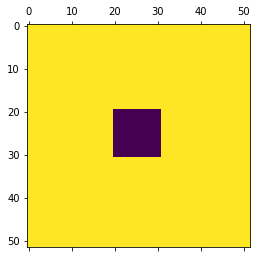

In [9]:
# Set the idomain of the parent model in order to 
# define where the child model will be located
idomain = np.ones((nlay, nrow, ncol), dtype=np.int)
idomain[0, 20:31, 20:31] = 0
plt.matshow(idomain[0])

In [10]:
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,idomain=idomain,
                              delr=delr, delc=delc,
                              top=top, botm=botm)

In [11]:
# initial conditions
ic = fp.mf6.ModflowGwfic(gwf, pname='ic', strt=0.)

In [12]:
# CHD equal to 0 at the boundaries
chd_spd = [[(0,0,i),0] for i in range(1,ncol)] + \
          [[(0,i,0),0] for i in range(nrow)] + \
          [[(0,nrow-1,i),0] for i in range(1,ncol)] + \
          [[(0,i,ncol-1),0] for i in range(1,nrow-1)]

In [13]:
chd = fp.mf6.ModflowGwfchd(gwf, save_flows=True,stress_period_data = chd_spd)

In [14]:
domain = np.zeros((nrow,ncol))

In [15]:
for i in chd_spd:
    domain[i[0][1],i[0][2]] = 1

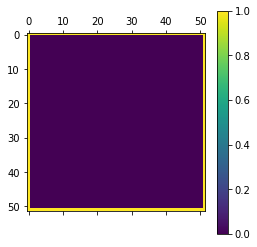

In [16]:
plt.matshow(domain)
plt.colorbar()

In [17]:
# npf 
hk=0.3

# node property flow
npf = fp.mf6.ModflowGwfnpf(gwf, 
                              icelltype=[0], 
                              k=[hk],
                              k33=[hk])

In [18]:
# storage
ss=0.0008
stor = fp.mf6.ModflowGwfsto(gwf, ss=ss, transient=True)

In [19]:
lgr=Lgr(nlay, nrow, ncol,delr,delc,0,-1,idomain,20,1)

/Users/mnfienen/Documents/GIT/flopy/flopy/utils/util_array.py:1708: UserWarning: Util2d: setting integer dtype from int64 to int32
  .format(dtype))


In [20]:
# create child gwf model
cmodel_name = 'child'
cgwf = fp.mf6.ModflowGwf(sim, modelname=cmodel_name,
                           model_nam_file='child.nam')

cgwf.name_file.save_flows = True
cnlay, cnrow, cncol = lgr.get_shape()
cdelr, cdelc = lgr.get_delr_delc()
ctop, cbotm = lgr.get_top_botm()
xorigin, yorigin = lgr.get_lower_left()
cidomain = lgr.get_idomain()
cgwf.modelgrid.set_coord_info(xoff=xorigin, yoff=yorigin)
cdis = fp.mf6.ModflowGwfdis(cgwf, nlay=cnlay, nrow=cnrow, ncol=cncol,
                               delr=cdelr, delc=cdelc,
                               top=ctop, botm=cbotm, idomain=cidomain,
                               xorigin=xorigin, yorigin=yorigin)
cic = fp.mf6.ModflowGwfic(cgwf, pname='ic', strt=0.)
cnpf = fp.mf6.ModflowGwfnpf(cgwf,  
                              icelltype=[0], 
                              k=[hk],
                              k33=[hk])

welspd = [[(cnlay - 1, int(cnrow / 2), int(cncol / 2)), -1.16]]
wel = fp.mf6.ModflowGwfwel(cgwf, print_input=True,
                              stress_period_data=welspd)
oc = fp.mf6.ModflowGwfoc(cgwf, pname='oc', budget_filerecord='{}.cbc'.format(cmodel_name),
                            head_filerecord='{}.hds'.format(cmodel_name),
                            headprintrecord=[('COLUMNS', 10, 'WIDTH', 15,
                                              'DIGITS', 6, 'GENERAL')],
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])
stor = fp.mf6.ModflowGwfsto(cgwf, ss=ss, transient=True)

# exchange information
exchangedata = lgr.get_exchange_data(angldegx=True, cdist=True)
nexg = len(exchangedata)
gwfe = fp.mf6.ModflowGwfgwf(sim, exgtype='gwf6-gwf6', 
                               exgmnamea='theis', exgmnameb='child', 
                               nexg=nexg, auxiliary=[('angldegx', 'cdist')], 
                               exchangedata=exchangedata)

sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing package theis_mf6.gwfgwf...
  writing model theis...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 204 based on size of stress_period_data
    writing package npf...
    writing package sto...
  writing model child...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package oc...
    writing package sto...
FloPy is using the following  executable to run the model: /Users/mnfienen/Documents/bin/MAC_VERSIONS_USGS/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL


(True, [])

In [21]:
fname = os.path.join(model_dir, 'child.hds')
hdobj = fp.utils.HeadFile(fname)
head = hdobj.get_alldata()

In [22]:
head.shape

(75, 1, 220, 220)

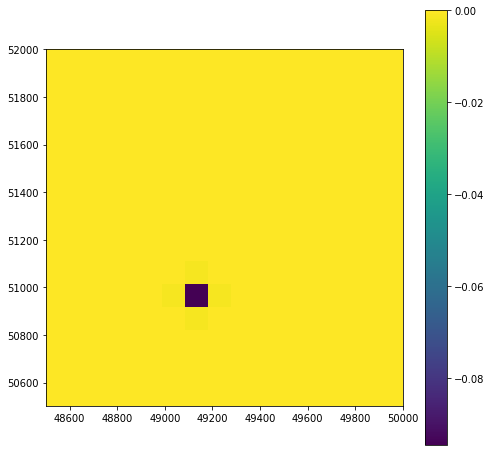

In [23]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mm = fp.plot.PlotMapView(cgwf, ax=ax)
v=mm.plot_array(head[10,0,:,:])
plt.xlim((48500,50000))
plt.ylim((50500,52000))
plt.colorbar(v)


In [24]:
with PdfPages('theis_mf_lgr.pdf') as pdfout:
    for i, chead in enumerate(head):
        printhead = np.squeeze(chead)
        plt.figure(figsize=(8,8))
        plt.imshow(#-printhead[100:120,100:120],
                   -printhead,
                  interpolation='nearest',
                  vmin=0,
                  vmax=2.7)
        plt.colorbar()
        plt.title('Theis-o-matic --> timestep{0}'.format(i))
        pdfout.savefig()
        plt.close()
        